# **MUHAMMAD WALEED KHAN-451539**,
# **SAQLAIN AYUB-451612,**
# **M. ZAKRIYA**

*`DEEP LEARNING PROJECT`*

`**IMAGE FORGERY USING CNN**`

# SUBMITTED ON:*` 08-MAY-2024`*

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

In [43]:
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import json
import seaborn as sns

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
from tqdm.notebook import tqdm

In [44]:
#converts input image to ela applied image
def convert_to_ela_image(path,quality):

    original_image = Image.open(path).convert('RGB')

    #resaving input image at the desired quality
    resaved_file_name = 'resaved_image.jpg'     #predefined filename for resaved image
    original_image.save(resaved_file_name,'JPEG',quality=quality)
    resaved_image = Image.open(resaved_file_name)

    #pixel difference between original and resaved image
    ela_image = ImageChops.difference(original_image,resaved_image)

    #scaling factors are calculated from pixel extremas
    extrema = ela_image.getextrema()
    max_difference = max([pix[1] for pix in extrema])
    if max_difference ==0:
        max_difference = 1
    scale = 350.0 / max_difference

    #enhancing elaimage to brighten the pixels
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    ela_image.save("ela_image.png")
    return ela_image

In [25]:
from zipfile import ZipFile

In [26]:
with ZipFile('drive/MyDrive/Data/MData.zip', 'r') as zipObj:
  zipObj.extractall('drive/MyDrive/Data/test')

In [27]:
def prepare_image(image_path):
    image_size = (128, 128)
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0         #normalizing the array values obtained from input image

In [28]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [29]:
#adding authentic images

path = '/content/drive/MyDrive/Data/test/archives/CASIA1/Au'       #folder path of the authentic images in the dataset
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(path, filename)
        X.append(prepare_image(full_path))
        Y.append(1)     # label for authentic images

print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/800 [00:00<?, ?it/s]

Total images: 790
Total labels: 790


In [30]:
#adding forged images

path = '/content/drive/MyDrive/Data/test/archives/CASIA1/Sp'       #folder path of the forged images in the dataset
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(path, filename)
        X.append(prepare_image(full_path))
        Y.append(0)     # label for forged images

print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/921 [00:00<?, ?it/s]

Total images: 1711
Total labels: 1711


In [31]:
X = np.array(X)
Y = np.array(Y)
X = X.reshape(-1, 128, 128, 3)

In [32]:
# Training : Validation : Testing = 76 : 19 : 5
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size = 0.05, random_state=5)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)

print(f'Training images: {len(X_train)} , Training labels: {len(Y_train)}')
print(f'Validation images: {len(X_val)} , Validation labels: {len(Y_val)}')
print(f'Test images: {len(X_test)} , Test labels: {len(Y_test)}')

Training images: 1300 , Training labels: 1300
Validation images: 325 , Validation labels: 325
Test images: 86 , Test labels: 86


In [33]:
def build_model():
    model = Sequential()  # Sequential Model
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation = 'sigmoid'))
    return model

In [34]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 64)      4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 64)      102464    
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        102464    
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 26, 26, 64)        0         
 g2D)                                                   

In [35]:
epochs = 15
batch_size = 32

In [36]:
#Optimizer
from tensorflow.keras.optimizers.legacy import Adam
init_lr = 1e-4   #learning rate for the optimizer
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [37]:
#Early Stopping
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0,
                               patience = 10,
                               verbose = 0,
                               mode = 'auto')

In [38]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                 validation_data = (X_val, Y_val),
                 callbacks = [early_stopping])

Epoch 1/15
41/41 [==============================] - 579s 14s/step - loss: 0.6561 - accuracy: 0.6415 - val_loss: 0.6023 - val_accuracy: 0.7077
Epoch 2/15
41/41 [==============================] - 553s 14s/step - loss: 0.6309 - accuracy: 0.6592 - val_loss: 0.6113 - val_accuracy: 0.6738
Epoch 3/15
41/41 [==============================] - 547s 13s/step - loss: 0.5695 - accuracy: 0.7200 - val_loss: 0.5579 - val_accuracy: 0.7323
Epoch 4/15
41/41 [==============================] - 552s 14s/step - loss: 0.5462 - accuracy: 0.7477 - val_loss: 0.5594 - val_accuracy: 0.7538
Epoch 5/15
41/41 [==============================] - 553s 14s/step - loss: 0.5266 - accuracy: 0.7623 - val_loss: 0.5349 - val_accuracy: 0.7569
Epoch 6/15
41/41 [==============================] - 559s 14s/step - loss: 0.5172 - accuracy: 0.7654 - val_loss: 0.5274 - val_accuracy: 0.7538
Epoch 7/15
41/41 [==============================] - 558s 14s/step - loss: 0.5345 - accuracy: 0.7438 - val_loss: 0.5213 - val_accuracy: 0.7508
Epoch 

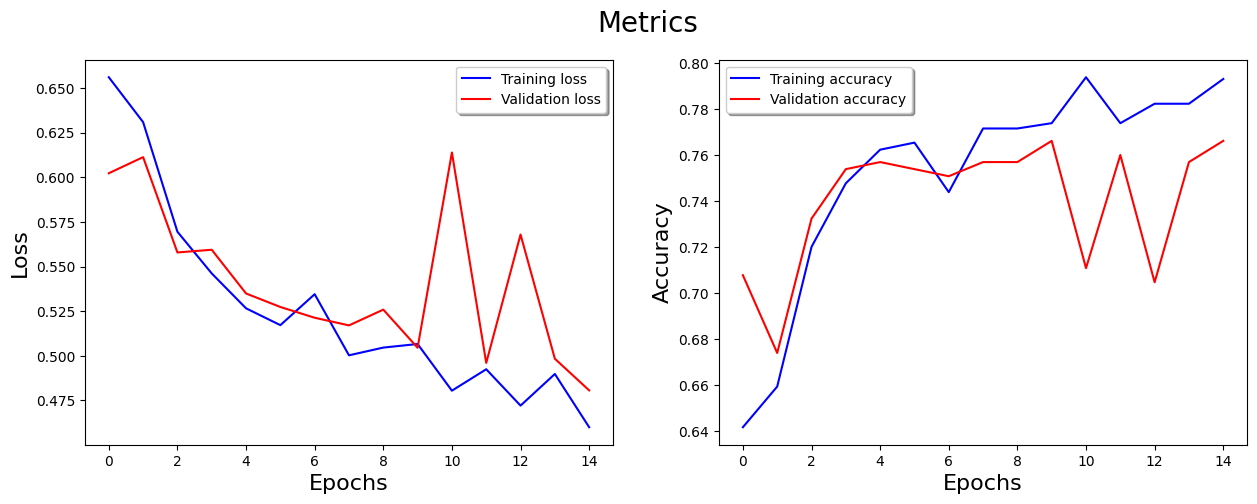

In [46]:
# Assuming `hist` contains the training history
history_dict = hist.history

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss
ax[0].plot(history_dict['loss'], color='b', label="Training loss")
ax[0].plot(history_dict['val_loss'], color='r', label="Validation loss")
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Loss', fontsize=16)
ax[0].legend(loc='best', shadow=True)

# Plot training and validation accuracy
ax[1].plot(history_dict['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history_dict['val_accuracy'], color='r', label="Validation accuracy")
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Accuracy', fontsize=16)
ax[1].legend(loc='best', shadow=True)

fig.suptitle('Metrics', fontsize=20)
plt.show()


In [47]:
def plot_confusion_matrix(cf_matrix):

    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()] #number of images in each classification block
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)] #percentage value of images in each block w.r.t total images

    axes_labels=['Forged', 'Authentic']
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='',cmap="flare" , xticklabels=axes_labels, yticklabels=axes_labels)

    plot_xlabel = plt.xlabel('Predicted labels', fontsize = 13)
    plot_ylabel = plt.ylabel('True labels', fontsize = 13)
    plot_title = plt.title('Confusion Matrix', fontsize= 10,fontweight='bold')

11/11 [==============================] - 43s 4s/step


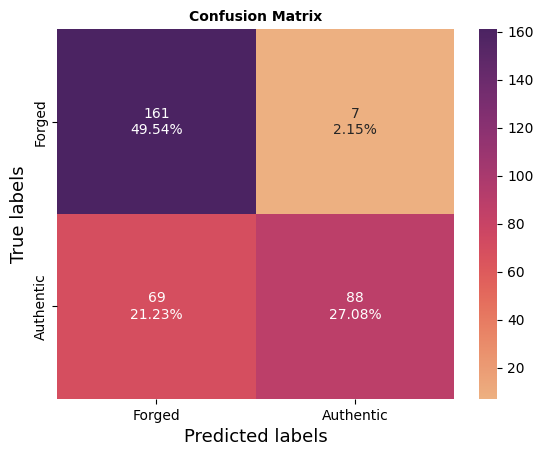

In [48]:
Y_pred = model.predict(X_val)               # Predict the values from the validation dataset
Y_pred_classes = np.round(Y_pred)           # roundoff the sigmoid value
Y_true = Y_val

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)     # compute the confusion matrix
plot_confusion_matrix(confusion_mtx)                         # plot the confusion matrix

In [49]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.70      0.96      0.81       168
           1       0.93      0.56      0.70       157

    accuracy                           0.77       325
   macro avg       0.81      0.76      0.75       325
weighted avg       0.81      0.77      0.76       325



In [50]:
class_names = ['Forged', 'Authentic']

In [51]:
# Testing accuracy
correct_test = 0 #correctly predicted test images
total_test = 0   #total test images

for index,image in enumerate(tqdm(X_test,desc="Processing Images : ")):
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model.predict(image)
    y_pred_class = np.round(y_pred)
    total_test += 1
    if y_pred_class == Y_test[index]: #if prediction is correct
        correct_test += 1

print(f'Total test images: {total_test}\nCorrectly predicted images: {correct_test}\nAccuracy: {correct_test / total_test * 100.0} %')

Processing Images :   0%|          | 0/86 [00:00<?, ?it/s]

1/1 [==============================] - 0s 201ms/step
Total test images: 86
Correctly predicted images: 71
Accuracy: 82.55813953488372 %


In [53]:
from keras.models import Sequential
from keras.layers import Dense

# Define the MLP model
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(128*128*3,)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
mlp_history = mlp_model.fit(X_train.reshape(-1, 128*128*3), Y_train, validation_data=(X_val.reshape(-1, 128*128*3), Y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

# Evaluate the model
mlp_loss, mlp_accuracy = mlp_model.evaluate(X_test.reshape(-1, 128*128*3), Y_test)
print(f'MLP Model - Test Loss: {mlp_loss}, Test Accuracy: {mlp_accuracy}')


Epoch 1/15
41/41 [==============================] - 11s 236ms/step - loss: 0.9362 - accuracy: 0.5208 - val_loss: 0.8287 - val_accuracy: 0.4708
Epoch 2/15
41/41 [==============================] - 5s 124ms/step - loss: 0.6857 - accuracy: 0.6046 - val_loss: 0.6872 - val_accuracy: 0.5662
Epoch 3/15
41/41 [==============================] - 5s 116ms/step - loss: 0.6137 - accuracy: 0.6769 - val_loss: 0.6967 - val_accuracy: 0.6246
Epoch 4/15
41/41 [==============================] - 6s 140ms/step - loss: 0.5515 - accuracy: 0.7469 - val_loss: 0.7035 - val_accuracy: 0.6000
Epoch 5/15
41/41 [==============================] - 5s 112ms/step - loss: 0.5327 - accuracy: 0.7569 - val_loss: 0.6704 - val_accuracy: 0.6000
Epoch 6/15
41/41 [==============================] - 4s 107ms/step - loss: 0.4975 - accuracy: 0.7662 - val_loss: 0.6512 - val_accuracy: 0.6338
Epoch 7/15
41/41 [==============================] - 5s 131ms/step - loss: 0.2985 - accuracy: 0.9262 - val_loss: 0.7999 - val_accuracy: 0.5723
Epoch

In [54]:
def build_fnn_model():
    model = Sequential()
    model.add(Flatten(input_shape=(128, 128, 3)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

fnn_model = build_fnn_model()


In [55]:
models_accuracy = {

    'MLP': (mlp_loss, mlp_accuracy)

}

for model_name, (loss, accuracy) in models_accuracy.items():
    print(f'{model_name} - Test Loss: {loss}, Test Accuracy: {accuracy}')

# Additional analysis such as plotting training/validation curves, confusion matrix, classification report, etc.


MLP - Test Loss: 0.6850742697715759, Test Accuracy: 0.6744186282157898


In [56]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn_classifier.fit(X_train.reshape(X_train.shape[0], -1), Y_train)

# Predict on validation set
knn_predictions = knn_classifier.predict(X_val.reshape(X_val.shape[0], -1))

# Evaluate accuracy
knn_accuracy = np.mean(knn_predictions == Y_val)
print(f'KNN Model - Validation Accuracy: {knn_accuracy}')

# Predict on test set
knn_test_predictions = knn_classifier.predict(X_test.reshape(X_test.shape[0], -1))

# Evaluate accuracy on test set
knn_test_accuracy = np.mean(knn_test_predictions == Y_test)
print(f'KNN Model - Test Accuracy: {knn_test_accuracy}')


KNN Model - Validation Accuracy: 0.5538461538461539
KNN Model - Test Accuracy: 0.5465116279069767


In [57]:
from sklearn.naive_bayes import GaussianNB

# Initialize Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train.reshape(X_train.shape[0], -1), Y_train)

# Predict on validation set
nb_predictions = nb_classifier.predict(X_val.reshape(X_val.shape[0], -1))

# Evaluate accuracy
nb_accuracy = np.mean(nb_predictions == Y_val)
print(f'Gaussian Naive Bayes Model - Validation Accuracy: {nb_accuracy}')

# Predict on test set
nb_test_predictions = nb_classifier.predict(X_test.reshape(X_test.shape[0], -1))

# Evaluate accuracy on test set
nb_test_accuracy = np.mean(nb_test_predictions == Y_test)
print(f'Gaussian Naive Bayes Model - Test Accuracy: {nb_test_accuracy}')


Gaussian Naive Bayes Model - Validation Accuracy: 0.5384615384615384
Gaussian Naive Bayes Model - Test Accuracy: 0.6046511627906976


In [58]:
from sklearn.svm import SVC

# Initialize SVM classifier
svm_classifier = SVC()

# Train the classifier
svm_classifier.fit(X_train.reshape(X_train.shape[0], -1), Y_train)

# Predict on validation set
svm_predictions = svm_classifier.predict(X_val.reshape(X_val.shape[0], -1))

# Evaluate accuracy
svm_accuracy = np.mean(svm_predictions == Y_val)
print(f'SVM Model - Validation Accuracy: {svm_accuracy}')

# Predict on test set
svm_test_predictions = svm_classifier.predict(X_test.reshape(X_test.shape[0], -1))

# Evaluate accuracy on test set
svm_test_accuracy = np.mean(svm_test_predictions == Y_test)
print(f'SVM Model - Test Accuracy: {svm_test_accuracy}')


SVM Model - Validation Accuracy: 0.7107692307692308
SVM Model - Test Accuracy: 0.6627906976744186


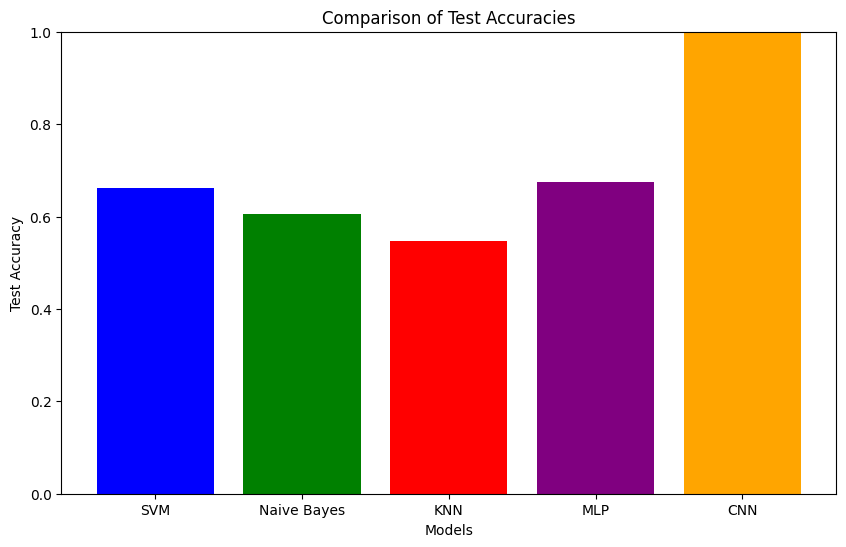

In [59]:
import matplotlib.pyplot as plt

# Define the accuracies
accuracies = [svm_test_accuracy, nb_test_accuracy, knn_test_accuracy, mlp_accuracy , correct_test / total_test * 100.0]
models = ['SVM', 'Naive Bayes', 'KNN', 'MLP' , 'CNN']

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Test Accuracies')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.show()





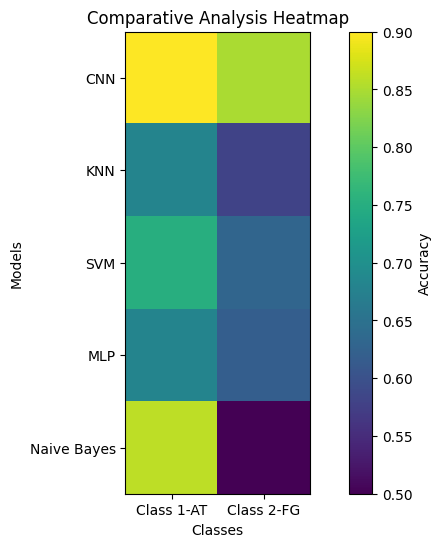

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and classes
models = ['CNN', 'KNN', 'SVM', 'MLP', 'Naive Bayes']
classes = ['Class 1-AT', 'Class 2-FG',]  # AT: AUTHENTIC, FG: FORGED

# Define the evaluation metric values for each model and class (replace with actual values)
evaluation_matrix = np.array([
    [0.90, 0.85],
    [0.68, 0.58],
    [0.75, 0.63],
    [0.68, 0.62],
    [0.86, 0.50]
])

# Plot the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(evaluation_matrix, cmap='viridis', interpolation='nearest')

# Add colorbar
plt.colorbar(label='Accuracy')

# Set ticks and labels
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(models)), models)

# Add labels
plt.xlabel('Classes')
plt.ylabel('Models')

# Add title
plt.title('Comparative Analysis Heatmap')

# Display the heatmap
plt.show()


In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(Y_true, Y_pred_classes)
recall = recall_score(Y_true, Y_pred_classes)
f1 = f1_score(Y_true, Y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.9263157894736842
Recall: 0.5605095541401274
F1 Score: 0.6984126984126984


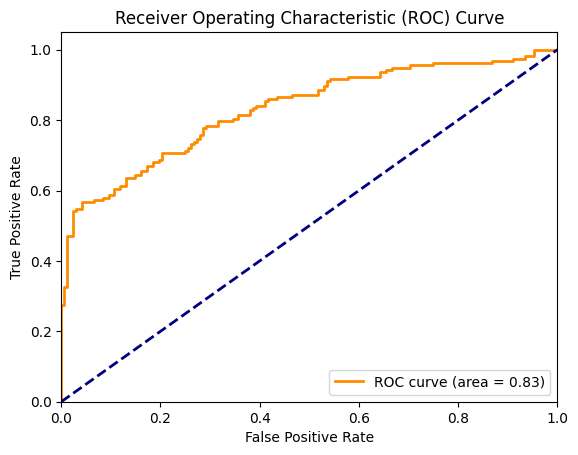

AUC: 0.8312101910828026


In [61]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_true, Y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("AUC:", roc_auc)


In [66]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/Data/DeepModel.hdf5')

In [ ]:
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np

# Load your trained model
model_path = '/content/drive/MyDrive/Data/DeepModel.hdf5'
model = tf.keras.models.load_model(model_path)

# Function to make predictions
def predict(image):
    # Preprocess the image
    image = np.array(image.resize((128, 128))) / 255.0  # Resize and normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(image)

    # Decode prediction into class labels
    if prediction[0][0] < 0.5:
        prediction_label = 'Authentic'
    else:
        prediction_label = 'Forged'

    return prediction_label

# Streamlit UI
st.title('Image Forgery Detection')
st.write('Upload an image for prediction')

# File upload
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

# Prediction logic
if uploaded_file is not None:
    # Display uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)

    # Make prediction
    prediction = predict(image)

    # Display prediction results
    st.write('Prediction:')
    st.write(prediction)


In [98]:
!wget -q -O - ipv4.icanhazip.com


35.237.73.195


In [2]:
! streamlit run app.py & npx localtunnel --port 8501

/bin/bash: line 1: streamlit: command not found
npx: installed 22 in 2.38s
^C
